# Clustering based on BYTES, PACKETS, DURATION

## Preparing a dataset

Load the dataset.

In [71]:
from cesnet_datazoo.datasets import CESNET_QUIC22, CESNET_TLS22

dataset = CESNET_QUIC22(data_root="data/CESNET_QUIC22/", size="XS", silent=True)

Prepare the dataset with config and see its columns.

In [72]:
from cesnet_datazoo.config import DatasetConfig

dataset_config = DatasetConfig(
    dataset=dataset,
    train_period_name="W-2022-44",
    train_size=10_000,
    use_packet_histograms=True,
)
dataset.set_dataset_config_and_initialize(dataset_config)

data_df = dataset.get_train_df()
data_df.columns

Index(['PPI', 'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION',
       'PPI_LEN', 'PPI_ROUNDTRIPS', 'PPI_DURATION', 'FLOW_ENDREASON_IDLE',
       'FLOW_ENDREASON_ACTIVE', 'FLOW_ENDREASON_OTHER', 'PSIZE_BIN1',
       'PSIZE_BIN2', 'PSIZE_BIN3', 'PSIZE_BIN4', 'PSIZE_BIN5', 'PSIZE_BIN6',
       'PSIZE_BIN7', 'PSIZE_BIN8', 'PSIZE_BIN1_REV', 'PSIZE_BIN2_REV',
       'PSIZE_BIN3_REV', 'PSIZE_BIN4_REV', 'PSIZE_BIN5_REV', 'PSIZE_BIN6_REV',
       'PSIZE_BIN7_REV', 'PSIZE_BIN8_REV', 'IPT_BIN1', 'IPT_BIN2', 'IPT_BIN3',
       'IPT_BIN4', 'IPT_BIN5', 'IPT_BIN6', 'IPT_BIN7', 'IPT_BIN8',
       'IPT_BIN1_REV', 'IPT_BIN2_REV', 'IPT_BIN3_REV', 'IPT_BIN4_REV',
       'IPT_BIN5_REV', 'IPT_BIN6_REV', 'IPT_BIN7_REV', 'IPT_BIN8_REV', 'APP'],
      dtype='object')

Get only the columns that are needed for clustering.

In [73]:
import numpy as np

features_to_extract =["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION", "PPI_LEN", "PPI_ROUNDTRIPS", "PPI_DURATION"]

features_array = data_df[features_to_extract].to_numpy()
app_array = data_df[["APP"]].to_numpy().reshape(-1)

## Analysis

Discover statistics of the dataset.

In [74]:
data_df[features_to_extract].describe()

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION,PPI_LEN,PPI_ROUNDTRIPS,PPI_DURATION
count,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,39.747501,128.002197,1.391133e+04,1.409761e+05,9.715365,23.166300,4.545200,3.534939
std,181.154236,1009.719971,1.261262e+05,1.257955e+06,30.136263,7.282363,1.889616,13.841331
min,1.000000,1.000000,1.228000e+03,7.500000e+01,0.000459,2.000000,1.000000,0.000000
25%,8.000000,9.000000,2.730000e+03,3.258000e+03,0.094244,17.000000,3.000000,0.077000
50%,12.000000,13.000000,4.191000e+03,5.296500e+03,0.216142,25.000000,4.000000,0.155000
75%,22.000000,24.000000,7.101500e+03,1.080075e+04,5.090615,30.000000,6.000000,0.562250
max,9408.000000,49713.000000,5.979904e+06,6.154108e+07,326.258301,30.000000,12.000000,213.985001


Head of the dataset.

In [75]:
data_df[[*features_to_extract, "APP"]].head()

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION,PPI_LEN,PPI_ROUNDTRIPS,PPI_DURATION,APP
0,15.0,15.0,2931.0,3921.0,0.101522,30.0,6.0,0.102,55
1,8.0,8.0,3069.0,2869.0,0.068021,16.0,3.0,0.068,78
2,14.0,17.0,3928.0,12297.0,0.051717,30.0,3.0,0.026,68
3,8.0,9.0,2300.0,3191.0,0.082868,17.0,3.0,0.083,50
4,9.0,9.0,2427.0,3060.0,0.286362,18.0,5.0,0.286,12


In [76]:
data_df["APP"].value_counts()

APP
62    683
59    636
41    632
66    611
55    555
     ... 
23      1
69      1
34      1
2       1
16      1
Name: count, Length: 101, dtype: int64

## Categorization of original classes

Define the original clustering using dataset's categories.

In [77]:
categories_enum = {category: i for i, category in dataset._tables_cat_enum.items()}
app_to_categories = dataset.class_info.categories_mapping
app_enum = {i: app for i, app in dataset._tables_app_enum.items()}
app_to_categories.update({
    "bongacams": "Streaming media",
    "gothbb": "E-commerce",
    "vkontakte": "Social",
    "poe-ninja": "Games",
    "unpkg": "Streaming media",
    "easylist": "Other services and APIs",
    "default-background": "default",
    "uber": "Other services and APIs",
})

categories_array = np.array([categories_enum[app_to_categories[app_enum[app]]] for app in app_array])

Choose the correct clusters from the dataset: categories or apps.

In [87]:
# convert dataframe app column to category name
category_df = data_df[["APP"]].copy()
category_df["APP"] = category_df["APP"].apply(lambda x: app_to_categories[app_enum[x]])

category_df.value_counts()

APP                    
Streaming media            3287
Other services and APIs    1955
Advertising                1031
Games                      1026
Authentication services     945
E-commerce                  658
File sharing                411
Social                      237
Mail                        189
Information systems         167
Blogs & News                 44
Instant messaging            26
Antivirus                    11
Analytics & Telemetry         8
Search                        2
default                       2
Videoconferencing             1
Name: count, dtype: int64

## Preprocessing

Define a pipeline for preprocessing.

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
])

preprocessed_array = preprocessing_pipeline.fit_transform(features_array)

## Clustering

Define function for DBSCAN clustering.

In [57]:
import hdbscan

def hdbscan_clustering(data, min_cluster_size=5, min_samples=5):
    return hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples).fit(data)

Perform DBSCAN clustering.

In [58]:
model = hdbscan_clustering(preprocessed_array, min_cluster_size=3, min_samples=3)
labels = model.labels_[:]

## Postprocessing

Remove outliers.

In [59]:
import numpy as np

outliers = np.where(model.labels_ == -1)
# no_outliers_array = np.delete(preprocessed_array, outliers)
# no_outliers_clusters_app = np.delete(correct_clusters_array, outliers)
# no_outliers_labels = np.delete(model.labels_, outliers)

f"Number of outliers: {len(outliers[0])}"

'Number of outliers: 2884'

## Evaluation

### Homogeneity, completeness and V-measure

In [60]:
from sklearn.metrics import homogeneity_completeness_v_measure

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(categories_array, labels)
f"Homogeneity (each cluster contains only members of a single class): {homogeneity}", f"Completeness (all members of a given class are assigned to the same cluster): {completeness}", f"V-measure: {v_measure}"

('Homogeneity (each cluster contains only members of a single class): 0.27883157887794036',
 'Completeness (all members of a given class are assigned to the same cluster): 0.11109678080100062',
 'V-measure: 0.1588870879999881')

In [61]:
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(app_array, labels)
f"Homogeneity (each cluster contains only members of a single class): {homogeneity}", f"Completeness (all members of a given class are assigned to the same cluster): {completeness}", f"V-measure: {v_measure}"

('Homogeneity (each cluster contains only members of a single class): 0.37645804955509526',
 'Completeness (all members of a given class are assigned to the same cluster): 0.27277890704275615',
 'V-measure: 0.3163400181135852')

### Fowlkes-Mallows index

In [62]:
from sklearn.metrics import fowlkes_mallows_score

"FM score:", fowlkes_mallows_score(labels, categories_array)

('FM score:', 0.12190691147766132)

### Pair matrix

In [63]:
from sklearn.metrics import pair_confusion_matrix

matrix = pair_confusion_matrix(categories_array, labels)
f"In true labelling: together, but in predicted: not  {matrix[1, 0]}", f"In true labelling: not together, but in predicted: together  {matrix[0, 1]}", f"In true labelling: together, and in predicted: together  {matrix[1, 1]}", f"In true labelling: not together, and in predicted: not together  {matrix[0, 0]}"

('In true labelling: together, but in predicted: not  16826902',
 'In true labelling: not together, but in predicted: together  6979038',
 'In true labelling: together, and in predicted: together  1522624',
 'In true labelling: not together, and in predicted: not together  74661436')

In [64]:
matrix = pair_confusion_matrix(app_array, labels)
f"In true labelling: together, but in predicted: not  {matrix[1, 0]}", f"In true labelling: not together, but in predicted: together  {matrix[0, 1]}", f"In true labelling: together, and in predicted: together  {matrix[1, 1]}", f"In true labelling: not together, and in predicted: not together  {matrix[0, 0]}"

('In true labelling: together, but in predicted: not  3457170',
 'In true labelling: not together, but in predicted: together  8146548',
 'In true labelling: together, and in predicted: together  355114',
 'In true labelling: not together, and in predicted: not together  88031168')

## Visualization

Define function for visualization.

In [65]:
import matplotlib.pyplot as plt

axis_zoom = [0, 6, -2, 4]

def plot_clusters(data, label, axis=True):
    plt.figure(figsize=(10, 10))
    plt.scatter(data[:, 0], data[:, 1], c=label)
    
    plt.axis(axis)
    
max(labels)


689

Visualize the clusters.

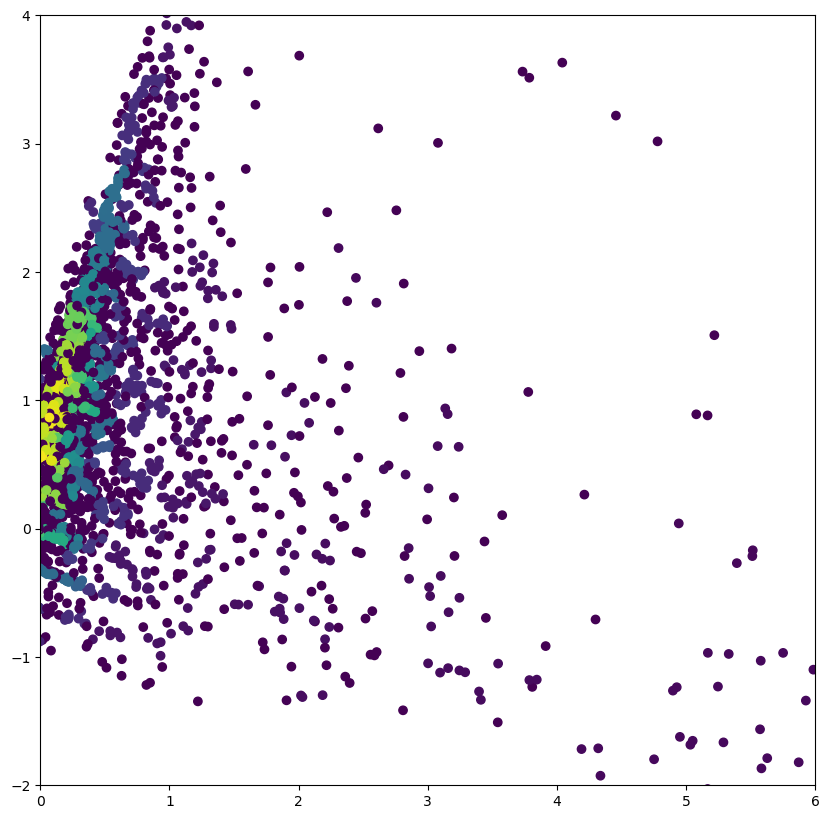

In [66]:
plot_clusters(preprocessed_array, labels, axis_zoom)
# plot_clusters(no_outliers_array, no_outliers_labels, [-0.1, 0.2, -0.1, 0.1])

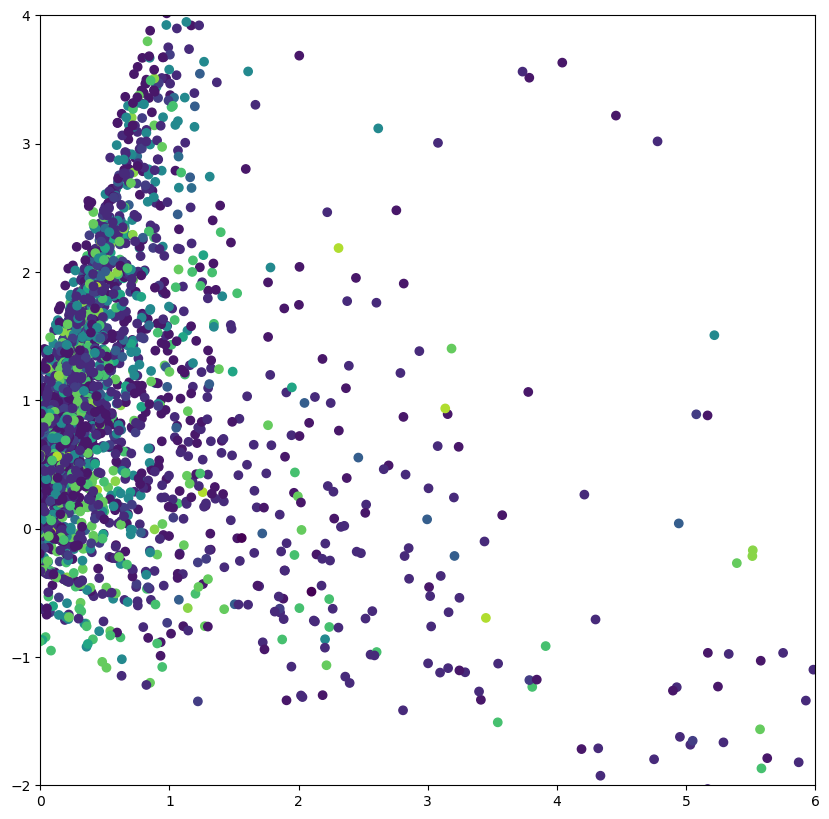

In [67]:
plot_clusters(preprocessed_array, categories_array, axis_zoom)

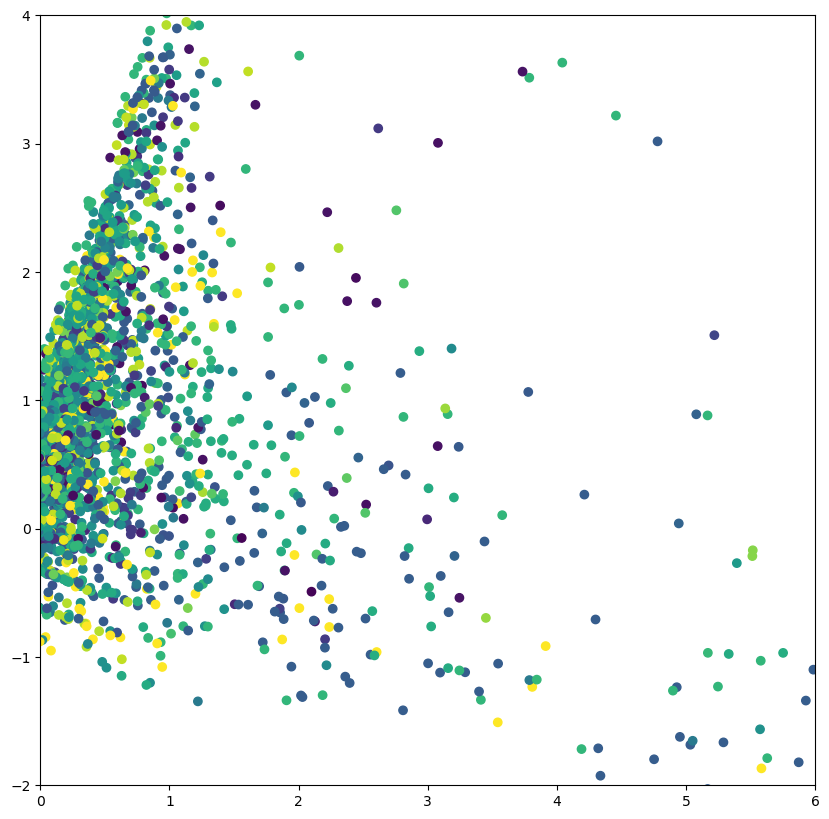

In [68]:
plot_clusters(preprocessed_array, app_array, axis_zoom)
# plot_clusters(no_outliers_array, no_outliers_clusters_app, [-0.1, 0.2, -0.1, 0.1])

C:\Users\nikol\miniconda3\envs\bachelors-diploma\Lib\site-packages\hdbscan\plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


<Axes: ylabel='$\\lambda$ value'>

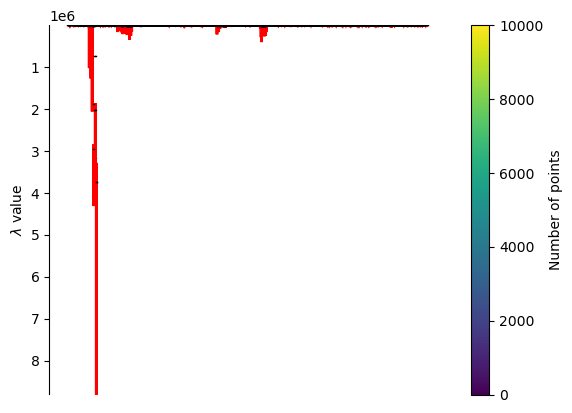

In [69]:
model.condensed_tree_.plot(select_clusters=True)

<Axes: ylabel='distance'>

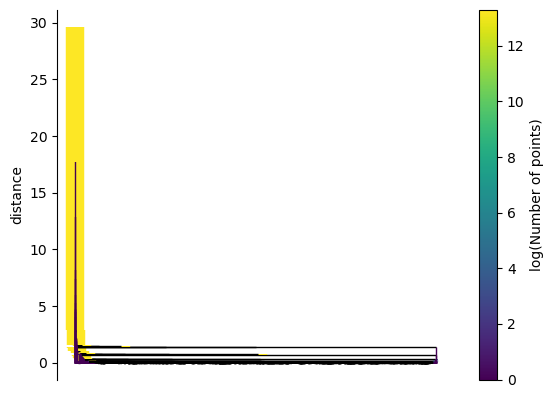

In [70]:
model.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

In [88]:
tree = model.condensed_tree_.to_pandas()
tree[tree.child_size > 1]


,parent,child,lambda_val,child_size
20,10000,10001,0.649675,5
21,10000,10002,0.649675,9975
29,10002,10003,0.651311,3
30,10002,10004,0.651311,9970
47,10004,10005,0.934888,22
...,...,...,...,...
11698,11725,11730,360.144298,10
11701,11730,11731,386.196678,4
11702,11730,11732,386.196678,6
11718,11728,11733,799.817000,5
